In [1]:
# path = '/home/dpanina/share/rete_tools/examples/'
# path = '/Users/Daria/Dev/Retentioneering/retentioneering-tools-new-arch/'

In [1]:
import sys
# # sys.path.insert(0, '/home/dpanina/retentioneering-tools-new-arch/')
#
sys.path.insert(0, '..')

# Инициация графа

In [2]:
import pandas as pd

from src.eventstream.eventstream import Eventstream
from src.eventstream.schema import RawDataSchema, EventstreamSchema
from src.graph.p_graph import PGraph, EventsNode

raw_data = pd.read_csv( 'simple-onlineshop.csv')

raw_data_schema = RawDataSchema(
                            event_name="event", 
                            event_timestamp="timestamp", 
                            user_id="user_id")

source = Eventstream(
    raw_data=raw_data,
    raw_data_schema=raw_data_schema,
    schema=EventstreamSchema()
)

graph = PGraph(source_stream=source)


In [3]:
raw_data_schema

RawDataSchema(event_name='event', event_timestamp='timestamp', user_id='user_id', event_type=None, custom_cols=[])

In [4]:
raw_data.head(8)

,user_id,event,timestamp
0,219483890,catalog,2019-11-01 17:59:13.273932
1,219483890,product1,2019-11-01 17:59:28.459271
2,219483890,cart,2019-11-01 17:59:29.502214
3,219483890,catalog,2019-11-01 17:59:32.557029
4,964964743,catalog,2019-11-01 21:38:19.283663
5,964964743,cart,2019-11-01 21:38:36.761221
6,964964743,delivery_choice,2019-11-01 21:38:37.564693
7,629881394,main,2019-11-01 22:28:54.791683


In [5]:
source.to_dataframe().head(8)

,event_id,event_type,event_index,event_name,event_timestamp,user_id
0,217e0c97-fa1e-4b07-b26d-bf63f59c3aef,raw,0,catalog,2019-11-01 17:59:13.273932,219483890
1,ddf423f0-2cd8-4897-bbb4-ed37662dac3d,raw,1,product1,2019-11-01 17:59:28.459271,219483890
2,a2fd316a-7479-4281-8c4b-b20381ffe03d,raw,2,cart,2019-11-01 17:59:29.502214,219483890
3,c77bc89d-5029-43b2-8251-8473a6946e69,raw,3,catalog,2019-11-01 17:59:32.557029,219483890
4,d40bf9df-2d1c-4aa3-a803-192e16b8a016,raw,4,catalog,2019-11-01 21:38:19.283663,964964743
5,dbfc2883-4ed1-404f-84a1-8c5b390926c5,raw,5,cart,2019-11-01 21:38:36.761221,964964743
6,8b1cd3d3-4d88-4dec-b278-6c22d5beed9e,raw,6,delivery_choice,2019-11-01 21:38:37.564693,964964743
7,0658536e-424a-4810-8636-d8f385cbb851,raw,7,main,2019-11-01 22:28:54.791683,629881394


In [6]:
source_df = source.to_dataframe()

In [7]:
source_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35381 entries, 0 to 35380
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   event_id         35381 non-null  object        
 1   event_type       35381 non-null  object        
 2   event_index      35381 non-null  int64         
 3   event_name       35381 non-null  object        
 4   event_timestamp  35381 non-null  datetime64[ns]
 5   user_id          35381 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 1.9+ MB


## Результат - общие вопросы

1) Конструкция вызовов довольно тяжеловесная, на каждую функцию надо вызвать 2 импорта, задать 2 инстанса и передать параметры словарем. Для аналитиков выглядит не слишком удобно

2)  get_parents() - выдача не оч информативная, есть сейчас возможность посмотреть, какие ноды до текущей?     - [<src.graph.p_graph.EventsNode at 0x7f3892298160>]

3) Можем ли задавать эту схему типов при создании eventstream?

 # Добавление синтетических событий

## StartEnd

### Описание работы функции

Для каждого пользователя добавляются события
```event_type = start, event = start, timestamp = timestamp(first_event)```
```event_type = end, event = end, timestamp = timestamp(end_event)```

In [9]:
from src.data_processors_lib.rete import StartEndEvents, StartEndEventsParams

In [10]:
start_end_events = EventsNode(
    StartEndEvents(params=StartEndEventsParams(**{}))
)

graph.add_node(
    node=start_end_events,
    parents=[graph.root]
)

result = graph.combine(
    node=start_end_events
)
result.to_dataframe().head(8)

,event_id,event_type,event_index,event_name,event_timestamp,user_id
0,471f400b-1451-4d93-b66c-9909e00751e6,start,0,start,2019-11-01 17:59:13.273932,219483890.0
1,ee8dc3b4-53f8-4f26-84a7-9a3d4b24dd2d,raw,1,catalog,2019-11-01 17:59:13.273932,219483890.0
2,73126e06-f817-470e-a397-0cf844023720,raw,2,product1,2019-11-01 17:59:28.459271,219483890.0
3,11bf77c7-7fd8-4b6d-a3aa-89bc8f833c4e,raw,3,cart,2019-11-01 17:59:29.502214,219483890.0
4,c633b530-c6f7-4e88-aca1-4b8ac61e0ced,raw,4,catalog,2019-11-01 17:59:32.557029,219483890.0
5,b62f26b4-8d12-448f-994e-42748ffc1b7a,start,5,start,2019-11-01 21:38:19.283663,964964743.0
6,1dd47e39-bcd0-4a11-9970-66c3ddaace26,raw,6,catalog,2019-11-01 21:38:19.283663,964964743.0
7,e41dd2c3-f09b-467a-b714-626efa161922,raw,7,cart,2019-11-01 21:38:36.761221,964964743.0


In [11]:
df = result.to_dataframe()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42883 entries, 0 to 42882
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   event_id         42883 non-null  object        
 1   event_type       42883 non-null  object        
 2   event_index      42883 non-null  int64         
 3   event_name       42883 non-null  object        
 4   event_timestamp  42883 non-null  datetime64[ns]
 5   user_id          42883 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 2.3+ MB


In [12]:
print(len(df[df['user_id'] == 219483890]))
df[df['user_id'] == 219483890]

19


,event_id,event_type,event_index,event_name,event_timestamp,user_id
0,471f400b-1451-4d93-b66c-9909e00751e6,start,0,start,2019-11-01 17:59:13.273932,219483890.0
1,ee8dc3b4-53f8-4f26-84a7-9a3d4b24dd2d,raw,1,catalog,2019-11-01 17:59:13.273932,219483890.0
2,73126e06-f817-470e-a397-0cf844023720,raw,2,product1,2019-11-01 17:59:28.459271,219483890.0
3,11bf77c7-7fd8-4b6d-a3aa-89bc8f833c4e,raw,3,cart,2019-11-01 17:59:29.502214,219483890.0
4,c633b530-c6f7-4e88-aca1-4b8ac61e0ced,raw,4,catalog,2019-11-01 17:59:32.557029,219483890.0
2715,93386e57-8d24-443d-b8a4-3d6589043a04,raw,2715,main,2019-12-06 16:22:57.484842,219483890.0
2716,f41a1a8c-6505-467f-be21-a7fc4e801c63,raw,2716,catalog,2019-12-06 16:23:01.331109,219483890.0
2717,d0e89d8a-2880-44be-8fa6-c599d320e2ed,raw,2717,catalog,2019-12-06 16:23:48.116617,219483890.0
5721,2b36ef36-da8e-45ee-98cf-d1d6eb310258,raw,5721,main,2020-01-06 22:10:13.635011,219483890.0
5722,ab011b28-76c6-479d-84ca-0ac7eccfd1d9,raw,5722,catalog,2020-01-06 22:10:15.228575,219483890.0


In [13]:
print(len(source_df[source_df['user_id'] == 219483890]))
source_df[source_df['user_id'] == 219483890].sort_values('event_timestamp')

17


,event_id,event_type,event_index,event_name,event_timestamp,user_id
0,ee8dc3b4-53f8-4f26-84a7-9a3d4b24dd2d,raw,0,catalog,2019-11-01 17:59:13.273932,219483890
1,73126e06-f817-470e-a397-0cf844023720,raw,1,product1,2019-11-01 17:59:28.459271,219483890
2,11bf77c7-7fd8-4b6d-a3aa-89bc8f833c4e,raw,2,cart,2019-11-01 17:59:29.502214,219483890
3,c633b530-c6f7-4e88-aca1-4b8ac61e0ced,raw,3,catalog,2019-11-01 17:59:32.557029,219483890
2245,93386e57-8d24-443d-b8a4-3d6589043a04,raw,2245,main,2019-12-06 16:22:57.484842,219483890
2246,f41a1a8c-6505-467f-be21-a7fc4e801c63,raw,2246,catalog,2019-12-06 16:23:01.331109,219483890
2247,d0e89d8a-2880-44be-8fa6-c599d320e2ed,raw,2247,catalog,2019-12-06 16:23:48.116617,219483890
4836,2b36ef36-da8e-45ee-98cf-d1d6eb310258,raw,4836,main,2020-01-06 22:10:13.635011,219483890
4837,ab011b28-76c6-479d-84ca-0ac7eccfd1d9,raw,4837,catalog,2020-01-06 22:10:15.228575,219483890
4838,c46c026c-38cb-4194-bfb9-f4b592bd85f6,raw,4838,cart,2020-01-06 22:10:42.309028,219483890


In [14]:
check_id = source_df[source_df['user_id'] == 219483890]['event_id'][0]
df[df['event_id'] == check_id]

,event_id,event_type,event_index,event_name,event_timestamp,user_id
1,ee8dc3b4-53f8-4f26-84a7-9a3d4b24dd2d,raw,1,catalog,2019-11-01 17:59:13.273932,219483890.0


In [15]:
source_df[source_df['event_id'] == check_id]

,event_id,event_type,event_index,event_name,event_timestamp,user_id
0,ee8dc3b4-53f8-4f26-84a7-9a3d4b24dd2d,raw,0,catalog,2019-11-01 17:59:13.273932,219483890


In [16]:
source_df['user_id'].nunique(), df['user_id'].nunique()

(3751, 3751)

In [17]:
df[df['event_type'] == 'start']['event_type'].count(), df[df['event_type'] == 'end']['event_type'].count()

(3751, 3751)

In [18]:
df[df['event_type'] == 'raw']['event_type'].count(), source.to_dataframe()['event_type'].count()

(35381, 35381)

In [19]:
source_df['event_type'].value_counts()

raw    35381
Name: event_type, dtype: int64

In [20]:
df['event_type'].value_counts()

raw      35381
start     3751
end       3751
Name: event_type, dtype: int64

In [21]:
len(source_df), len(df)

(35381, 42883)

### Результат

1) [DONE] Исчезло событие, которое до этого было первым с event_id = '556697a2-7439-45c1-bd70-8d970ab7ef61'
Тоже самое произошло с событием End
result.to_dataframe(show_deleted=True) - то все нормально
2) [DONE] Количество raw событий после combine уменьшилось ровно на кол-во пользователей*2
Общая длина eventstream при этом не изменилась
3) [TODO] #params - не должно быть обязательных параметров

## NewResume

### Описание работы функции

Добавляются события new_user/resume_user

Это можно сделать двумя способами:
1) В параметр ```new_users_list = []``` передать список новых пользователей, для них добавятся события:
```event_type = new_user, event = new_user, timestamp = timestamp(first_event)```
При этом для всех остальных, добавятся события:
```event_type = resume, event = resume, timestamp = timestamp(first_event)```
<br>

2) Если параметр ```new_users_list = 'all'```
То всем пользователям добавятся события:
```event_type = new_user, event = new_user, timestamp = timestamp(first_event)```


In [22]:
from src.data_processors_lib.rete import NewResumeEvents, NewResumeParams

# new_user_list = [219483890]
new_user_list = 'all'
new_resume_events = EventsNode(
    NewResumeEvents(params=NewResumeParams(new_users_list=new_user_list)))


graph.add_node(
    node=new_resume_events,
    parents=[graph.root]
)

result = graph.combine(
    node=new_resume_events
)
result.to_dataframe().head(8)

,event_id,event_type,event_index,event_name,event_timestamp,user_id
0,a79291d0-2d08-4e79-957f-9bb5d2943ab3,new_user,0,new_user,2019-11-01 17:59:13.273932,219483890.0
1,ee8dc3b4-53f8-4f26-84a7-9a3d4b24dd2d,raw,1,catalog,2019-11-01 17:59:13.273932,219483890.0
2,73126e06-f817-470e-a397-0cf844023720,raw,2,product1,2019-11-01 17:59:28.459271,219483890.0
3,11bf77c7-7fd8-4b6d-a3aa-89bc8f833c4e,raw,3,cart,2019-11-01 17:59:29.502214,219483890.0
4,c633b530-c6f7-4e88-aca1-4b8ac61e0ced,raw,4,catalog,2019-11-01 17:59:32.557029,219483890.0
5,d238ef36-a22c-415d-be4b-4ece3edffd18,new_user,5,new_user,2019-11-01 21:38:19.283663,964964743.0
6,1dd47e39-bcd0-4a11-9970-66c3ddaace26,raw,6,catalog,2019-11-01 21:38:19.283663,964964743.0
7,e41dd2c3-f09b-467a-b714-626efa161922,raw,7,cart,2019-11-01 21:38:36.761221,964964743.0


In [23]:
df1 = result.to_dataframe()

In [24]:
source_df['event_type'].value_counts()

raw    35381
Name: event_type, dtype: int64

In [25]:
df1['event_type'].value_counts()

raw         35381
new_user     3751
Name: event_type, dtype: int64

In [26]:
len(df1), len(source_df)

(39132, 35381)

In [27]:
len(df1) - len(source_df)

3751

In [28]:
graph.get_parents(new_resume_events)

In [29]:
print(len(source_df[source_df['user_id'] == 219483890]))
source_df[source_df['user_id'] == 219483890].sort_values('event_timestamp')

17


,event_id,event_type,event_index,event_name,event_timestamp,user_id
0,ee8dc3b4-53f8-4f26-84a7-9a3d4b24dd2d,raw,0,catalog,2019-11-01 17:59:13.273932,219483890
1,73126e06-f817-470e-a397-0cf844023720,raw,1,product1,2019-11-01 17:59:28.459271,219483890
2,11bf77c7-7fd8-4b6d-a3aa-89bc8f833c4e,raw,2,cart,2019-11-01 17:59:29.502214,219483890
3,c633b530-c6f7-4e88-aca1-4b8ac61e0ced,raw,3,catalog,2019-11-01 17:59:32.557029,219483890
2245,93386e57-8d24-443d-b8a4-3d6589043a04,raw,2245,main,2019-12-06 16:22:57.484842,219483890
2246,f41a1a8c-6505-467f-be21-a7fc4e801c63,raw,2246,catalog,2019-12-06 16:23:01.331109,219483890
2247,d0e89d8a-2880-44be-8fa6-c599d320e2ed,raw,2247,catalog,2019-12-06 16:23:48.116617,219483890
4836,2b36ef36-da8e-45ee-98cf-d1d6eb310258,raw,4836,main,2020-01-06 22:10:13.635011,219483890
4837,ab011b28-76c6-479d-84ca-0ac7eccfd1d9,raw,4837,catalog,2020-01-06 22:10:15.228575,219483890
4838,c46c026c-38cb-4194-bfb9-f4b592bd85f6,raw,4838,cart,2020-01-06 22:10:42.309028,219483890


In [30]:
print(len(df1[df1['user_id'] == 219483890]))
df1[df1['user_id'] == 219483890].sort_values('event_timestamp')

18


,event_id,event_type,event_index,event_name,event_timestamp,user_id
0,a79291d0-2d08-4e79-957f-9bb5d2943ab3,new_user,0,new_user,2019-11-01 17:59:13.273932,219483890.0
1,ee8dc3b4-53f8-4f26-84a7-9a3d4b24dd2d,raw,1,catalog,2019-11-01 17:59:13.273932,219483890.0
2,73126e06-f817-470e-a397-0cf844023720,raw,2,product1,2019-11-01 17:59:28.459271,219483890.0
3,11bf77c7-7fd8-4b6d-a3aa-89bc8f833c4e,raw,3,cart,2019-11-01 17:59:29.502214,219483890.0
4,c633b530-c6f7-4e88-aca1-4b8ac61e0ced,raw,4,catalog,2019-11-01 17:59:32.557029,219483890.0
2553,93386e57-8d24-443d-b8a4-3d6589043a04,raw,2553,main,2019-12-06 16:22:57.484842,219483890.0
2554,f41a1a8c-6505-467f-be21-a7fc4e801c63,raw,2554,catalog,2019-12-06 16:23:01.331109,219483890.0
2555,d0e89d8a-2880-44be-8fa6-c599d320e2ed,raw,2555,catalog,2019-12-06 16:23:48.116617,219483890.0
5388,2b36ef36-da8e-45ee-98cf-d1d6eb310258,raw,5388,main,2020-01-06 22:10:13.635011,219483890.0
5389,ab011b28-76c6-479d-84ca-0ac7eccfd1d9,raw,5389,catalog,2020-01-06 22:10:15.228575,219483890.0


In [31]:
check_id = source_df[source_df['user_id'] == 219483890]['event_id'][0]
df1[df1['event_id'] == check_id]

,event_id,event_type,event_index,event_name,event_timestamp,user_id
1,ee8dc3b4-53f8-4f26-84a7-9a3d4b24dd2d,raw,1,catalog,2019-11-01 17:59:13.273932,219483890.0


In [32]:
print(len(source_df[source_df['user_id'] == 964964743]))
source_df[source_df['user_id'] == 964964743].sort_values('event_timestamp')

13


,event_id,event_type,event_index,event_name,event_timestamp,user_id
4,1dd47e39-bcd0-4a11-9970-66c3ddaace26,raw,4,catalog,2019-11-01 21:38:19.283663,964964743
5,e41dd2c3-f09b-467a-b714-626efa161922,raw,5,cart,2019-11-01 21:38:36.761221,964964743
6,9842ecfe-6246-4073-89a6-7996a7e61190,raw,6,delivery_choice,2019-11-01 21:38:37.564693,964964743
2439,64e3b5d4-fbf3-45ed-be1b-e428e6a2eb87,raw,2439,main,2019-12-09 01:42:22.801831,964964743
2440,41961e8a-9a91-4af9-8a98-8c52a7ea22f0,raw,2440,catalog,2019-12-09 01:42:23.617764,964964743
2441,bbe2ee2e-21fe-469e-b26f-d0a399eec37c,raw,2441,product2,2019-12-09 01:42:56.877340,964964743
2442,6f651ba6-fff4-4bfd-adeb-e2a762e93f1c,raw,2442,catalog,2019-12-09 01:43:05.436223,964964743
2443,0d6812eb-b8e1-4d7d-ba04-62f61d2074d1,raw,2443,catalog,2019-12-09 01:43:36.923178,964964743
2444,71f430ce-4fc8-468d-83ff-611096d0e6b9,raw,2444,product2,2019-12-09 01:43:41.174195,964964743
2445,06992a83-86d8-40dc-b01d-800f96cc9a1f,raw,2445,cart,2019-12-09 01:43:57.325569,964964743


In [33]:
print(len(df1[df1['user_id'] == 964964743]))
df1[df1['user_id'] == 964964743].sort_values('event_timestamp')

14


,event_id,event_type,event_index,event_name,event_timestamp,user_id
5,d238ef36-a22c-415d-be4b-4ece3edffd18,new_user,5,new_user,2019-11-01 21:38:19.283663,964964743.0
6,1dd47e39-bcd0-4a11-9970-66c3ddaace26,raw,6,catalog,2019-11-01 21:38:19.283663,964964743.0
7,e41dd2c3-f09b-467a-b714-626efa161922,raw,7,cart,2019-11-01 21:38:36.761221,964964743.0
8,9842ecfe-6246-4073-89a6-7996a7e61190,raw,8,delivery_choice,2019-11-01 21:38:37.564693,964964743.0
2768,64e3b5d4-fbf3-45ed-be1b-e428e6a2eb87,raw,2768,main,2019-12-09 01:42:22.801831,964964743.0
2769,41961e8a-9a91-4af9-8a98-8c52a7ea22f0,raw,2769,catalog,2019-12-09 01:42:23.617764,964964743.0
2770,bbe2ee2e-21fe-469e-b26f-d0a399eec37c,raw,2770,product2,2019-12-09 01:42:56.877340,964964743.0
2771,6f651ba6-fff4-4bfd-adeb-e2a762e93f1c,raw,2771,catalog,2019-12-09 01:43:05.436223,964964743.0
2772,0d6812eb-b8e1-4d7d-ba04-62f61d2074d1,raw,2772,catalog,2019-12-09 01:43:36.923178,964964743.0
2773,71f430ce-4fc8-468d-83ff-611096d0e6b9,raw,2773,product2,2019-12-09 01:43:41.174195,964964743.0


### зададим ноды последовательно

In [34]:
new_user_list = [219483890]

new_resume_events1 = EventsNode(
    NewResumeEvents(params=NewResumeParams(new_users_list=new_user_list)))


graph.add_node(
    node=new_resume_events1,
    parents=[start_end_events]
)

result_seq = graph.combine(
    node=new_resume_events1
)
result_seq.to_dataframe().head(8)

,event_id,event_type,event_index,event_name,event_timestamp,user_id
0,d5d013d7-c5f4-424c-83f1-a260ecc198ea,start,0,start,2019-11-01 17:59:13.273932,219483890.0
1,92c3542f-7c7d-4a8b-9d36-0d74dd028619,new_user,1,new_user,2019-11-01 17:59:13.273932,219483890.0
2,ee8dc3b4-53f8-4f26-84a7-9a3d4b24dd2d,raw,2,catalog,2019-11-01 17:59:13.273932,219483890.0
3,73126e06-f817-470e-a397-0cf844023720,raw,3,product1,2019-11-01 17:59:28.459271,219483890.0
4,11bf77c7-7fd8-4b6d-a3aa-89bc8f833c4e,raw,4,cart,2019-11-01 17:59:29.502214,219483890.0
5,c633b530-c6f7-4e88-aca1-4b8ac61e0ced,raw,5,catalog,2019-11-01 17:59:32.557029,219483890.0
6,248f873d-878d-419e-9d6b-89936b34a55f,start,6,start,2019-11-01 21:38:19.283663,964964743.0
7,6d4882cb-8661-4d95-8777-19651b1a3e80,resume,7,resume,2019-11-01 21:38:19.283663,964964743.0


In [35]:
len(result_seq.to_dataframe()), len(source_df)

(46634, 35381)

In [36]:
result_seq.to_dataframe()['event_type'].value_counts()

raw         35381
start        3751
end          3751
resume       3750
new_user        1
Name: event_type, dtype: int64

In [37]:
result.to_dataframe()['event_type'].value_counts()

raw         35381
new_user     3751
Name: event_type, dtype: int64

In [38]:
source_df['event_type'].value_counts()

raw    35381
Name: event_type, dtype: int64

In [39]:
df2 = result_seq.to_dataframe()

In [40]:
print(len(df2[df2['user_id'] == 219483890]))
df2[df2['user_id'] == 219483890].sort_values('event_timestamp')

20


,event_id,event_type,event_index,event_name,event_timestamp,user_id
0,d5d013d7-c5f4-424c-83f1-a260ecc198ea,start,0,start,2019-11-01 17:59:13.273932,219483890.0
1,92c3542f-7c7d-4a8b-9d36-0d74dd028619,new_user,1,new_user,2019-11-01 17:59:13.273932,219483890.0
2,ee8dc3b4-53f8-4f26-84a7-9a3d4b24dd2d,raw,2,catalog,2019-11-01 17:59:13.273932,219483890.0
3,73126e06-f817-470e-a397-0cf844023720,raw,3,product1,2019-11-01 17:59:28.459271,219483890.0
4,11bf77c7-7fd8-4b6d-a3aa-89bc8f833c4e,raw,4,cart,2019-11-01 17:59:29.502214,219483890.0
5,c633b530-c6f7-4e88-aca1-4b8ac61e0ced,raw,5,catalog,2019-11-01 17:59:32.557029,219483890.0
3023,93386e57-8d24-443d-b8a4-3d6589043a04,raw,3023,main,2019-12-06 16:22:57.484842,219483890.0
3024,f41a1a8c-6505-467f-be21-a7fc4e801c63,raw,3024,catalog,2019-12-06 16:23:01.331109,219483890.0
3025,d0e89d8a-2880-44be-8fa6-c599d320e2ed,raw,3025,catalog,2019-12-06 16:23:48.116617,219483890.0
6273,2b36ef36-da8e-45ee-98cf-d1d6eb310258,raw,6273,main,2020-01-06 22:10:13.635011,219483890.0


In [41]:
graph.get_parents(new_resume_events1)

### Результат

1) [DONE] Обсуждали, что можно задать вот так тип new_users_list: List[int] | str
у меня это не сработало
В итоге поправила - new_users_list: Union[str, List[int]]
2) [TODO] Можно ли как-то проставить конкретное значение "all"?
Пока добавила отбивку
3) [DONE] Дубликаты
    - Задвоились все raw события, кроме первого,
    - Первое событие удалилось по аналогии со start_end_events, проверила по id
    -new_user и resume проставился правильно c правильным timestamp
4) [TODO_analytics]
При задании new_resume_events, должна быть возможность задать параметр "all" - чтобы всем проставить new_user - нужен он такой? нужен ли такой для resume?

## LostPause

### Описание работы функции

Добавлять события lost/pause можно двумя способами:

1) В параметр ```lost_users_list = []``` передать список пользователей, которые ушли из продукта, для них добавятся события:
```event_type = lost, event = lost, timestamp = timestamp(last_raw_event)```
При этом для всех остальных, добавятся события:
```event_type = pause, event = pause, timestamp = timestamp(last_raw_event)```
Здесь можно опционально изменить дефолтную функцию, чтобы регулировать ```timestamp``` с которым будет добавлено синтетическое событие ```lost```

<br>

2) Или можно задать отсечку с помощью параметра ```lost_cutoff = [Tuple[float, str]]```
И тогда всем юзерам, у которых время между последним событием в его траектории и окончанием всего датасета - больше заданной отсечки, мы проставляем:
```event_type = lost, event = lost, timestamp = timestamp(last_raw_event)```
При этом для всех остальных, добавятся события:
```event_type = pause, event = pause, timestamp = timestamp(last_raw_event)```

### list

In [7]:
from src.data_processors_lib.rete import LostPauseEvents, LostPauseParams

lost_users_list_ = [964964743]

lost_pause_events = EventsNode(
    LostPauseEvents(params=LostPauseParams(lost_users_list=lost_users_list_)))

graph.add_node(
    node=lost_pause_events,
    parents=[graph.root]
)


result = graph.combine(
    node=lost_pause_events
)

TypeError: _custom_func_lost() takes 0 positional arguments but 1 was given

In [ ]:
df3 = result.to_dataframe()
print(source_df.duplicated(['event_name', 'event_timestamp', 'user_id']).sum())
print(df3.duplicated(['event_name', 'event_timestamp', 'user_id']).sum())

In [10]:
print(len(df3[df3['user_id'] == 964964743]))
df3[df3['user_id'] == 964964743]

NameError: name 'df3' is not defined

In [45]:
print(len(source_df[source_df['user_id'] == 964964743]))
source_df[source_df['user_id'] == 964964743]

13


,event_id,event_type,event_index,event_name,event_timestamp,user_id
4,1dd47e39-bcd0-4a11-9970-66c3ddaace26,raw,4,catalog,2019-11-01 21:38:19.283663,964964743
5,e41dd2c3-f09b-467a-b714-626efa161922,raw,5,cart,2019-11-01 21:38:36.761221,964964743
6,9842ecfe-6246-4073-89a6-7996a7e61190,raw,6,delivery_choice,2019-11-01 21:38:37.564693,964964743
2439,64e3b5d4-fbf3-45ed-be1b-e428e6a2eb87,raw,2439,main,2019-12-09 01:42:22.801831,964964743
2440,41961e8a-9a91-4af9-8a98-8c52a7ea22f0,raw,2440,catalog,2019-12-09 01:42:23.617764,964964743
2441,bbe2ee2e-21fe-469e-b26f-d0a399eec37c,raw,2441,product2,2019-12-09 01:42:56.877340,964964743
2442,6f651ba6-fff4-4bfd-adeb-e2a762e93f1c,raw,2442,catalog,2019-12-09 01:43:05.436223,964964743
2443,0d6812eb-b8e1-4d7d-ba04-62f61d2074d1,raw,2443,catalog,2019-12-09 01:43:36.923178,964964743
2444,71f430ce-4fc8-468d-83ff-611096d0e6b9,raw,2444,product2,2019-12-09 01:43:41.174195,964964743
2445,06992a83-86d8-40dc-b01d-800f96cc9a1f,raw,2445,cart,2019-12-09 01:43:57.325569,964964743


In [46]:
print(len(source_df[source_df['user_id'] == 629881394]))
print(len(df3[df3['user_id'] == 629881394]))
df3[df3['user_id'] == 629881394]

48
49


,event_id,event_type,event_index,event_name,event_timestamp,user_id
7,f4f84e3b-de9a-4e64-9313-81dd01f69413,raw,7,main,2019-11-01 22:28:54.791683,629881394.0
9,181a835b-641f-45c0-9831-259ccc30278e,raw,9,catalog,2019-11-01 22:29:01.049513,629881394.0
11,897d1105-0281-4040-940c-5c4e1b4945d2,raw,11,catalog,2019-11-01 22:29:32.322458,629881394.0
13,03fd3903-24b6-477f-b2c4-2ffa8e83b881,raw,13,catalog,2019-11-01 22:30:09.450839,629881394.0
14,6c9ceeb9-da22-4899-9801-1adce18549a4,raw,14,catalog,2019-11-01 22:31:05.565762,629881394.0
15,0d1b9fbf-19d8-43fa-ad79-2f8d6b043409,raw,15,main,2019-11-01 22:31:08.333560,629881394.0
16,0ea75b5f-ea1d-403a-bc5a-98a70775d7ee,raw,16,catalog,2019-11-01 22:31:09.010626,629881394.0
17,51b23cd2-b4ed-4de0-a4d6-2a9a112167c5,raw,17,product1,2019-11-01 22:31:10.416231,629881394.0
18,124e3f21-8985-4821-8e43-8d5f9de4de31,raw,18,catalog,2019-11-01 22:31:43.019527,629881394.0
19,5a06869f-0423-42ad-9252-6cff3d953e50,raw,19,catalog,2019-11-01 22:32:01.596163,629881394.0


In [47]:
len(source_df), len(df3)

(35381, 39132)

In [48]:
source_df['event_type'].value_counts()

raw    35381
Name: event_type, dtype: int64

In [49]:
df3.value_counts(['event_type'])

event_type
raw           35381
pause          3751
dtype: int64

In [50]:
print(len(df3[df3['user_id'] == 219483890]))
df3[df3['user_id'] == 219483890].sort_values('event_timestamp')

18


,event_id,event_type,event_index,event_name,event_timestamp,user_id
0,ee8dc3b4-53f8-4f26-84a7-9a3d4b24dd2d,raw,0,catalog,2019-11-01 17:59:13.273932,219483890.0
1,73126e06-f817-470e-a397-0cf844023720,raw,1,product1,2019-11-01 17:59:28.459271,219483890.0
2,11bf77c7-7fd8-4b6d-a3aa-89bc8f833c4e,raw,2,cart,2019-11-01 17:59:29.502214,219483890.0
3,c633b530-c6f7-4e88-aca1-4b8ac61e0ced,raw,3,catalog,2019-11-01 17:59:32.557029,219483890.0
2407,93386e57-8d24-443d-b8a4-3d6589043a04,raw,2407,main,2019-12-06 16:22:57.484842,219483890.0
2408,f41a1a8c-6505-467f-be21-a7fc4e801c63,raw,2408,catalog,2019-12-06 16:23:01.331109,219483890.0
2409,d0e89d8a-2880-44be-8fa6-c599d320e2ed,raw,2409,catalog,2019-12-06 16:23:48.116617,219483890.0
5169,2b36ef36-da8e-45ee-98cf-d1d6eb310258,raw,5169,main,2020-01-06 22:10:13.635011,219483890.0
5170,ab011b28-76c6-479d-84ca-0ac7eccfd1d9,raw,5170,catalog,2020-01-06 22:10:15.228575,219483890.0
5171,c46c026c-38cb-4194-bfb9-f4b592bd85f6,raw,5171,cart,2020-01-06 22:10:42.309028,219483890.0


In [51]:
print(len(source_df[source_df['user_id'] == 219483890]))
source_df[source_df['user_id'] == 219483890]

17


,event_id,event_type,event_index,event_name,event_timestamp,user_id
0,ee8dc3b4-53f8-4f26-84a7-9a3d4b24dd2d,raw,0,catalog,2019-11-01 17:59:13.273932,219483890
1,73126e06-f817-470e-a397-0cf844023720,raw,1,product1,2019-11-01 17:59:28.459271,219483890
2,11bf77c7-7fd8-4b6d-a3aa-89bc8f833c4e,raw,2,cart,2019-11-01 17:59:29.502214,219483890
3,c633b530-c6f7-4e88-aca1-4b8ac61e0ced,raw,3,catalog,2019-11-01 17:59:32.557029,219483890
2245,93386e57-8d24-443d-b8a4-3d6589043a04,raw,2245,main,2019-12-06 16:22:57.484842,219483890
2246,f41a1a8c-6505-467f-be21-a7fc4e801c63,raw,2246,catalog,2019-12-06 16:23:01.331109,219483890
2247,d0e89d8a-2880-44be-8fa6-c599d320e2ed,raw,2247,catalog,2019-12-06 16:23:48.116617,219483890
4836,2b36ef36-da8e-45ee-98cf-d1d6eb310258,raw,4836,main,2020-01-06 22:10:13.635011,219483890
4837,ab011b28-76c6-479d-84ca-0ac7eccfd1d9,raw,4837,catalog,2020-01-06 22:10:15.228575,219483890
4838,c46c026c-38cb-4194-bfb9-f4b592bd85f6,raw,4838,cart,2020-01-06 22:10:42.309028,219483890


### cutoff

In [52]:
from src.data_processors_lib.rete import LostPauseEvents, LostPauseParams

lost_cutoff_ = (3000, 's')

lost_pause_events_cutoff = EventsNode(
    LostPauseEvents(params=LostPauseParams(lost_cutoff=lost_cutoff_)))

graph.add_node(
    node=lost_pause_events_cutoff,
    parents=[graph.root]
)

result_cutoff = graph.combine(
    node=lost_pause_events_cutoff
)

,event_id,event_type,event_index,event_name,event_timestamp,user_id
0,ee8dc3b4-53f8-4f26-84a7-9a3d4b24dd2d,raw,0,catalog,2019-11-01 17:59:13.273932,219483890.0
1,73126e06-f817-470e-a397-0cf844023720,raw,1,product1,2019-11-01 17:59:28.459271,219483890.0
2,11bf77c7-7fd8-4b6d-a3aa-89bc8f833c4e,raw,2,cart,2019-11-01 17:59:29.502214,219483890.0
3,c633b530-c6f7-4e88-aca1-4b8ac61e0ced,raw,3,catalog,2019-11-01 17:59:32.557029,219483890.0
4,1dd47e39-bcd0-4a11-9970-66c3ddaace26,raw,4,catalog,2019-11-01 21:38:19.283663,964964743.0
5,e41dd2c3-f09b-467a-b714-626efa161922,raw,5,cart,2019-11-01 21:38:36.761221,964964743.0
6,9842ecfe-6246-4073-89a6-7996a7e61190,raw,6,delivery_choice,2019-11-01 21:38:37.564693,964964743.0
7,f4f84e3b-de9a-4e64-9313-81dd01f69413,raw,7,main,2019-11-01 22:28:54.791683,629881394.0


In [53]:
df4 = result_cutoff.to_dataframe()
print(source_df.duplicated(['event_name', 'event_timestamp', 'user_id']).sum())
print(df4.duplicated(['event_name', 'event_timestamp', 'user_id']).sum())

0
3092


In [54]:
print(len(df4[df4['user_id'] == 964964743]))
df4[df4['user_id'] == 964964743]

14


,event_id,event_type,event_index,event_name,event_timestamp,user_id
4,1dd47e39-bcd0-4a11-9970-66c3ddaace26,raw,4,catalog,2019-11-01 21:38:19.283663,964964743.0
5,e41dd2c3-f09b-467a-b714-626efa161922,raw,5,cart,2019-11-01 21:38:36.761221,964964743.0
6,9842ecfe-6246-4073-89a6-7996a7e61190,raw,6,delivery_choice,2019-11-01 21:38:37.564693,964964743.0
2618,64e3b5d4-fbf3-45ed-be1b-e428e6a2eb87,raw,2618,main,2019-12-09 01:42:22.801831,964964743.0
2619,41961e8a-9a91-4af9-8a98-8c52a7ea22f0,raw,2619,catalog,2019-12-09 01:42:23.617764,964964743.0
2620,bbe2ee2e-21fe-469e-b26f-d0a399eec37c,raw,2620,product2,2019-12-09 01:42:56.877340,964964743.0
2621,6f651ba6-fff4-4bfd-adeb-e2a762e93f1c,raw,2621,catalog,2019-12-09 01:43:05.436223,964964743.0
2622,0d6812eb-b8e1-4d7d-ba04-62f61d2074d1,raw,2622,catalog,2019-12-09 01:43:36.923178,964964743.0
2623,71f430ce-4fc8-468d-83ff-611096d0e6b9,raw,2623,product2,2019-12-09 01:43:41.174195,964964743.0
2624,06992a83-86d8-40dc-b01d-800f96cc9a1f,raw,2624,cart,2019-12-09 01:43:57.325569,964964743.0


In [55]:
print(len(source_df[source_df['user_id'] == 964964743]))
source_df[source_df['user_id'] == 964964743]

13


,event_id,event_type,event_index,event_name,event_timestamp,user_id
4,1dd47e39-bcd0-4a11-9970-66c3ddaace26,raw,4,catalog,2019-11-01 21:38:19.283663,964964743
5,e41dd2c3-f09b-467a-b714-626efa161922,raw,5,cart,2019-11-01 21:38:36.761221,964964743
6,9842ecfe-6246-4073-89a6-7996a7e61190,raw,6,delivery_choice,2019-11-01 21:38:37.564693,964964743
2439,64e3b5d4-fbf3-45ed-be1b-e428e6a2eb87,raw,2439,main,2019-12-09 01:42:22.801831,964964743
2440,41961e8a-9a91-4af9-8a98-8c52a7ea22f0,raw,2440,catalog,2019-12-09 01:42:23.617764,964964743
2441,bbe2ee2e-21fe-469e-b26f-d0a399eec37c,raw,2441,product2,2019-12-09 01:42:56.877340,964964743
2442,6f651ba6-fff4-4bfd-adeb-e2a762e93f1c,raw,2442,catalog,2019-12-09 01:43:05.436223,964964743
2443,0d6812eb-b8e1-4d7d-ba04-62f61d2074d1,raw,2443,catalog,2019-12-09 01:43:36.923178,964964743
2444,71f430ce-4fc8-468d-83ff-611096d0e6b9,raw,2444,product2,2019-12-09 01:43:41.174195,964964743
2445,06992a83-86d8-40dc-b01d-800f96cc9a1f,raw,2445,cart,2019-12-09 01:43:57.325569,964964743


In [56]:
print(len(source_df[source_df['user_id'] == 629881394]))
# source_df[source_df['user_id'] == 629881394]
print(len(df4[df4['user_id'] == 629881394]))
df4[df4['user_id'] == 629881394]

48
49


,event_id,event_type,event_index,event_name,event_timestamp,user_id
7,f4f84e3b-de9a-4e64-9313-81dd01f69413,raw,7,main,2019-11-01 22:28:54.791683,629881394.0
9,181a835b-641f-45c0-9831-259ccc30278e,raw,9,catalog,2019-11-01 22:29:01.049513,629881394.0
11,897d1105-0281-4040-940c-5c4e1b4945d2,raw,11,catalog,2019-11-01 22:29:32.322458,629881394.0
13,03fd3903-24b6-477f-b2c4-2ffa8e83b881,raw,13,catalog,2019-11-01 22:30:09.450839,629881394.0
14,6c9ceeb9-da22-4899-9801-1adce18549a4,raw,14,catalog,2019-11-01 22:31:05.565762,629881394.0
15,0d1b9fbf-19d8-43fa-ad79-2f8d6b043409,raw,15,main,2019-11-01 22:31:08.333560,629881394.0
16,0ea75b5f-ea1d-403a-bc5a-98a70775d7ee,raw,16,catalog,2019-11-01 22:31:09.010626,629881394.0
17,51b23cd2-b4ed-4de0-a4d6-2a9a112167c5,raw,17,product1,2019-11-01 22:31:10.416231,629881394.0
18,124e3f21-8985-4821-8e43-8d5f9de4de31,raw,18,catalog,2019-11-01 22:31:43.019527,629881394.0
19,5a06869f-0423-42ad-9252-6cff3d953e50,raw,19,catalog,2019-11-01 22:32:01.596163,629881394.0


In [57]:
len(source_df), len(df4)

(35381, 39132)

In [58]:
source_df['event_type'].value_counts()

raw    35381
Name: event_type, dtype: int64

In [59]:
df4.value_counts(['event_type'])

event_type
raw           35381
lost           3744
pause             7
dtype: int64

In [60]:
print(len(df4[df4['user_id'] == 219483890]))
df4[df4['user_id'] == 219483890].sort_values('event_timestamp')

18


,event_id,event_type,event_index,event_name,event_timestamp,user_id
0,ee8dc3b4-53f8-4f26-84a7-9a3d4b24dd2d,raw,0,catalog,2019-11-01 17:59:13.273932,219483890.0
1,73126e06-f817-470e-a397-0cf844023720,raw,1,product1,2019-11-01 17:59:28.459271,219483890.0
2,11bf77c7-7fd8-4b6d-a3aa-89bc8f833c4e,raw,2,cart,2019-11-01 17:59:29.502214,219483890.0
3,c633b530-c6f7-4e88-aca1-4b8ac61e0ced,raw,3,catalog,2019-11-01 17:59:32.557029,219483890.0
2407,93386e57-8d24-443d-b8a4-3d6589043a04,raw,2407,main,2019-12-06 16:22:57.484842,219483890.0
2408,f41a1a8c-6505-467f-be21-a7fc4e801c63,raw,2408,catalog,2019-12-06 16:23:01.331109,219483890.0
2409,d0e89d8a-2880-44be-8fa6-c599d320e2ed,raw,2409,catalog,2019-12-06 16:23:48.116617,219483890.0
5169,2b36ef36-da8e-45ee-98cf-d1d6eb310258,raw,5169,main,2020-01-06 22:10:13.635011,219483890.0
5170,ab011b28-76c6-479d-84ca-0ac7eccfd1d9,raw,5170,catalog,2020-01-06 22:10:15.228575,219483890.0
5171,c46c026c-38cb-4194-bfb9-f4b592bd85f6,raw,5171,cart,2020-01-06 22:10:42.309028,219483890.0


In [61]:
print(len(source_df[source_df['user_id'] == 219483890]))
source_df[source_df['user_id'] == 219483890]

17


,event_id,event_type,event_index,event_name,event_timestamp,user_id
0,ee8dc3b4-53f8-4f26-84a7-9a3d4b24dd2d,raw,0,catalog,2019-11-01 17:59:13.273932,219483890
1,73126e06-f817-470e-a397-0cf844023720,raw,1,product1,2019-11-01 17:59:28.459271,219483890
2,11bf77c7-7fd8-4b6d-a3aa-89bc8f833c4e,raw,2,cart,2019-11-01 17:59:29.502214,219483890
3,c633b530-c6f7-4e88-aca1-4b8ac61e0ced,raw,3,catalog,2019-11-01 17:59:32.557029,219483890
2245,93386e57-8d24-443d-b8a4-3d6589043a04,raw,2245,main,2019-12-06 16:22:57.484842,219483890
2246,f41a1a8c-6505-467f-be21-a7fc4e801c63,raw,2246,catalog,2019-12-06 16:23:01.331109,219483890
2247,d0e89d8a-2880-44be-8fa6-c599d320e2ed,raw,2247,catalog,2019-12-06 16:23:48.116617,219483890
4836,2b36ef36-da8e-45ee-98cf-d1d6eb310258,raw,4836,main,2020-01-06 22:10:13.635011,219483890
4837,ab011b28-76c6-479d-84ca-0ac7eccfd1d9,raw,4837,catalog,2020-01-06 22:10:15.228575,219483890
4838,c46c026c-38cb-4194-bfb9-f4b592bd85f6,raw,4838,cart,2020-01-06 22:10:42.309028,219483890


### Результат

1) [DONE] Нельзя задать единицу измерения отсечки, сейчас тип - lost_cutoff: Optional[List[int]]
2) [DONE] - ломается на этапе импорта из-за параметра функции, если
3) [DONE] Combine - часть событий задваивается, но не очень понятно по какой логике
4) [TODO] Локально возникает ошибка TypeError: _default_func_positive() takes 2 positional arguments but 3 were given
5) [TODO_analytics] Продумать общую логику работы - сейчас можно проставить lost/pause или по отсечке, или по списку и функции. И то и другое задавать нельзя.
    - По отсечке - Если от последнего события в траектории прошло больше времени отсечки, то добавляется событие lost, если меньше - pause
    - lost_users_list - список юзеров, которым проставляется событие lost, остальным - pause, Сейчас по списку проставляется - pause

## Truncated

### Описание работы функции

Для ```left_truncated_cutoff``` добавляет событие ```event_type=truncated_left, event=truncated_left``` в начало траектории пользователя, если последнее событие пользователя отстоит от конца датасета больше, чем на ```left_truncated_cutoff```.
 <br>
Для ```right_truncated_cutoff``` добавляет события ```event_type=truncated_right, event=truncated_right``` в конец траектории пользователя, если первое событие пользователя отстоит от начала датасета больше, чем на ```right_truncated_cutoff```.
 <br>
Отсечки удобно определять с помощью гистограмм ```preprocessing.plot_time_delta```

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime as dt
import time

def plot_time_delta(df: pd.DataFrame,
                    dataset_event='start', #'dataset_users_diff=('start', 'end')
                    users_event='end',
                    cutoff=None,
                    uom='s',
                    bins='auto',
                    log_scale=(False, False),
                    figsize=(15,10),
                    l_bound = 1,
                    r_bound = None,
                    alpha: float = 0.4
                    ):

    uom_dict = {'s': 1,
                'm': 60,
                'h': 3600,
                 'd': 24*3600}

    user_col = 'user_id'
    time_col = 'event_timestamp'

    df_time = df.groupby(user_col)[[time_col]].agg({min, max})
    df_time.columns = df_time.columns.get_level_values(1)
    df_time = df_time.reset_index()

    if dataset_event == 'start' and  users_event == 'start':
    #'start_start'
        df_time['time_diff'] = (df_time['min'] - df_time['min'].min())

    elif dataset_event == 'end' and  users_event == 'end':
    #'end_end'
        df_time['time_diff'] = (df_time['max'].max() - df_time['max'])

    elif dataset_event == 'start' and  users_event == 'end':
    #'start_endu'
        df_time['time_diff'] = (df_time['max'] - df_time['min'].min())

    elif dataset_event == 'end' and  users_event == 'start':
    #'end_startu'
        df_time['time_diff'] = (df_time['max'].max() - df_time['min'])

    df_time = df_time[df_time['time_diff'] != 0]
    df_time['time_diff'] = df_time['time_diff'].dt.total_seconds()

    if uom!= 's':
        df_time['time_diff'] = df_time['time_diff']/uom_dict[uom]

    df_time = df_time[(df_time['time_diff'] > l_bound)]

    if r_bound != None:
        df_time = df_time[(df_time['time_diff'] < r_bound)]

    plt.figure(figsize=figsize)

    ax = sns.histplot(x=df_time['time_diff'],
             bins=bins, #'auto',
             log_scale=log_scale,
             color='tab:blue',
             alpha = alpha, # прозрачность
             edgecolor='black',
                     )

    if log_scale[0]:
        plt.xlabel(f'time, {uom}, log_scale ')
    else:
        plt.xlabel(f'time, {uom}')

    if log_scale[1]:
        plt.ylabel('Count users, log_scale ')
    else:
        plt.ylabel('Count users')
    if cutoff:
        plt.axvline(x=cutoff, linewidth=1, color = 'r', linestyle='--', label = 'cutoff')
    plt.title(f'Time between {dataset_event} event of full dataset and {users_event} event of each user')
    plt.show()

In [63]:
source_df.head(1)

,event_id,event_type,event_index,event_name,event_timestamp,user_id
0,ee8dc3b4-53f8-4f26-84a7-9a3d4b24dd2d,raw,0,catalog,2019-11-01 17:59:13.273932,219483890


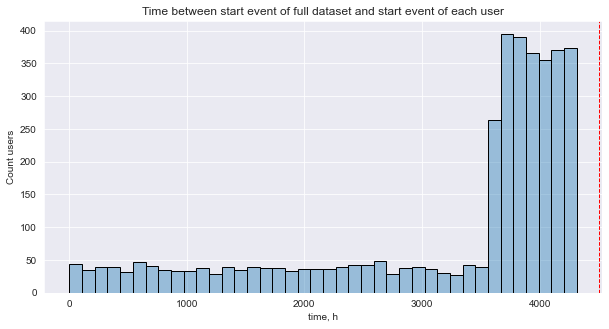

In [64]:
# задавать с какой стороны отсчитывать отсечку - справа или слева

plot_time_delta(source_df,
                    dataset_event='start', #'dataset_users_diff=('start', 'end')
                    users_event='start',
                    cutoff=4500,
                    uom='h',
                    bins=40,
                    log_scale=(False, False),
                    figsize=(10,5),
                    l_bound = 1,
                    r_bound = None
                    )

In [65]:
from src.data_processors_lib.rete import TruncatedEvents, TruncatedParams
params = {
    'left_truncated_cutoff': (1000, 'h'),
    'right_truncated_cutoff': (4000, 'h')
}

truncated_events = EventsNode(
    TruncatedEvents(params=TruncatedParams(**params)))


graph.add_node(
    node=truncated_events,
    parents=[graph.root]
)

result = graph.combine(
    node=truncated_events
)
result.to_dataframe().head(8)

,event_id,event_type,event_index,event_name,event_timestamp,user_id
0,ee8dc3b4-53f8-4f26-84a7-9a3d4b24dd2d,raw,0,catalog,2019-11-01 17:59:13.273932,219483890.0
1,2a8c4b7a-4178-4f3b-ae41-b40efe49f4c1,truncated_left,1,truncated_left,2019-11-01 17:59:13.273932,219483890.0
2,73126e06-f817-470e-a397-0cf844023720,raw,2,product1,2019-11-01 17:59:28.459271,219483890.0
3,11bf77c7-7fd8-4b6d-a3aa-89bc8f833c4e,raw,3,cart,2019-11-01 17:59:29.502214,219483890.0
4,c633b530-c6f7-4e88-aca1-4b8ac61e0ced,raw,4,catalog,2019-11-01 17:59:32.557029,219483890.0
5,1dd47e39-bcd0-4a11-9970-66c3ddaace26,raw,5,catalog,2019-11-01 21:38:19.283663,964964743.0
6,368d793c-7fb9-46a0-9683-2f1dc2a73da8,truncated_left,6,truncated_left,2019-11-01 21:38:19.283663,964964743.0
7,e41dd2c3-f09b-467a-b714-626efa161922,raw,7,cart,2019-11-01 21:38:36.761221,964964743.0


In [66]:
df5 = result.to_dataframe()
print(source_df.duplicated(['event_name', 'event_timestamp', 'user_id']).sum())
df5.duplicated(['event_name', 'event_timestamp', 'user_id']).sum()

0


0

In [67]:
df5['user_id'].nunique()

3751

In [68]:
df5.value_counts('event_type')

event_type
raw                35381
truncated_right     1080
truncated_left       967
dtype: int64

In [69]:
df5[df5['event_type'] == 'truncated_right']['user_id']

25577    973860052.0
25599    102919503.0
25625    146993449.0
25633    169208046.0
25644    147898568.0
            ...     
37383    125426031.0
37391     26773318.0
37396    965024600.0
37403    831491833.0
37419    962761227.0
Name: user_id, Length: 1080, dtype: float64

In [70]:
print(len(df5[df5['user_id'] == 973860052]))
df5[df5['user_id'] == 973860052]

9


,event_id,event_type,event_index,event_name,event_timestamp,user_id
25569,d4feb630-9dfc-4c53-80ce-1a0efd109fc4,raw,25569,main,2020-04-16 10:01:27.881445,973860052.0
25570,c9c00270-46c4-4dab-8b93-abcef1f7d6db,raw,25570,catalog,2020-04-16 10:01:32.436962,973860052.0
25571,32477b72-37bd-436e-9c5d-31fb4ef2969d,raw,25571,product2,2020-04-16 10:01:35.561178,973860052.0
25572,3a8e04f4-dc78-419e-b1d9-a9ae60873d25,raw,25572,cart,2020-04-16 10:01:51.293357,973860052.0
25573,c443b211-03df-4885-9dce-ef3c8141ff99,raw,25573,delivery_choice,2020-04-16 10:01:58.276434,973860052.0
25574,827268e2-f7ae-4652-9521-9eb208476d34,raw,25574,delivery_courier,2020-04-16 10:01:59.070049,973860052.0
25575,fd15dd5f-45b5-4e93-9f03-f4f885ed08e6,raw,25575,payment_choice,2020-04-16 10:01:59.221387,973860052.0
25576,56d7ed98-180e-4c19-a464-5434a8ad44bd,raw,25576,payment_done,2020-04-16 10:02:00.771862,973860052.0
25577,904864a9-e97c-45a5-9b52-d1888492843e,truncated_right,25577,truncated_right,2020-04-16 10:02:00.771862,973860052.0


In [71]:
print(len(source_df[source_df['user_id'] == 973860052]))
source_df[source_df['user_id'] == 973860052]

8


,event_id,event_type,event_index,event_name,event_timestamp,user_id
24602,d4feb630-9dfc-4c53-80ce-1a0efd109fc4,raw,24602,main,2020-04-16 10:01:27.881445,973860052
24603,c9c00270-46c4-4dab-8b93-abcef1f7d6db,raw,24603,catalog,2020-04-16 10:01:32.436962,973860052
24604,32477b72-37bd-436e-9c5d-31fb4ef2969d,raw,24604,product2,2020-04-16 10:01:35.561178,973860052
24605,3a8e04f4-dc78-419e-b1d9-a9ae60873d25,raw,24605,cart,2020-04-16 10:01:51.293357,973860052
24606,c443b211-03df-4885-9dce-ef3c8141ff99,raw,24606,delivery_choice,2020-04-16 10:01:58.276434,973860052
24607,827268e2-f7ae-4652-9521-9eb208476d34,raw,24607,delivery_courier,2020-04-16 10:01:59.070049,973860052
24608,fd15dd5f-45b5-4e93-9f03-f4f885ed08e6,raw,24608,payment_choice,2020-04-16 10:01:59.221387,973860052
24609,56d7ed98-180e-4c19-a464-5434a8ad44bd,raw,24609,payment_done,2020-04-16 10:02:00.771862,973860052


In [72]:
df5['event_timestamp'].min(), df5[df5['user_id'] == 973860052]['event_timestamp'].min()
(df5[df5['user_id'] == 973860052]['event_timestamp'].min() - df5['event_timestamp'].min()).total_seconds()/3600

4000.037390975833

In [73]:
24*0.666666666

15.999999984

In [74]:
4000/24

166.66666666666666

In [75]:
print(len(df5[df5['user_id'] == 964964743]))
df5[df5['user_id'] == 964964743]

14


,event_id,event_type,event_index,event_name,event_timestamp,user_id
5,1dd47e39-bcd0-4a11-9970-66c3ddaace26,raw,5,catalog,2019-11-01 21:38:19.283663,964964743.0
6,368d793c-7fb9-46a0-9683-2f1dc2a73da8,truncated_left,6,truncated_left,2019-11-01 21:38:19.283663,964964743.0
7,e41dd2c3-f09b-467a-b714-626efa161922,raw,7,cart,2019-11-01 21:38:36.761221,964964743.0
8,9842ecfe-6246-4073-89a6-7996a7e61190,raw,8,delivery_choice,2019-11-01 21:38:37.564693,964964743.0
2728,64e3b5d4-fbf3-45ed-be1b-e428e6a2eb87,raw,2728,main,2019-12-09 01:42:22.801831,964964743.0
2729,41961e8a-9a91-4af9-8a98-8c52a7ea22f0,raw,2729,catalog,2019-12-09 01:42:23.617764,964964743.0
2730,bbe2ee2e-21fe-469e-b26f-d0a399eec37c,raw,2730,product2,2019-12-09 01:42:56.877340,964964743.0
2731,6f651ba6-fff4-4bfd-adeb-e2a762e93f1c,raw,2731,catalog,2019-12-09 01:43:05.436223,964964743.0
2732,0d6812eb-b8e1-4d7d-ba04-62f61d2074d1,raw,2732,catalog,2019-12-09 01:43:36.923178,964964743.0
2733,71f430ce-4fc8-468d-83ff-611096d0e6b9,raw,2733,product2,2019-12-09 01:43:41.174195,964964743.0


In [76]:
df5['event_timestamp'].max(), df5[df5['user_id'] == 964964743]['event_timestamp'].max()
print(df5['event_timestamp'].max() - df5[df5['user_id'] == 964964743]['event_timestamp'].max())

142 days 11:04:08.828540


In [77]:
df5['event_timestamp'].max() - df5['event_timestamp'].min()

Timedelta('179 days 18:48:54.321458')

In [78]:
# отсечка 1000 часов
1000/24

41.666666666666664

In [79]:
print(len(source_df[source_df['user_id'] == 964964743]))
source_df[source_df['user_id'] == 964964743]

13


,event_id,event_type,event_index,event_name,event_timestamp,user_id
4,1dd47e39-bcd0-4a11-9970-66c3ddaace26,raw,4,catalog,2019-11-01 21:38:19.283663,964964743
5,e41dd2c3-f09b-467a-b714-626efa161922,raw,5,cart,2019-11-01 21:38:36.761221,964964743
6,9842ecfe-6246-4073-89a6-7996a7e61190,raw,6,delivery_choice,2019-11-01 21:38:37.564693,964964743
2439,64e3b5d4-fbf3-45ed-be1b-e428e6a2eb87,raw,2439,main,2019-12-09 01:42:22.801831,964964743
2440,41961e8a-9a91-4af9-8a98-8c52a7ea22f0,raw,2440,catalog,2019-12-09 01:42:23.617764,964964743
2441,bbe2ee2e-21fe-469e-b26f-d0a399eec37c,raw,2441,product2,2019-12-09 01:42:56.877340,964964743
2442,6f651ba6-fff4-4bfd-adeb-e2a762e93f1c,raw,2442,catalog,2019-12-09 01:43:05.436223,964964743
2443,0d6812eb-b8e1-4d7d-ba04-62f61d2074d1,raw,2443,catalog,2019-12-09 01:43:36.923178,964964743
2444,71f430ce-4fc8-468d-83ff-611096d0e6b9,raw,2444,product2,2019-12-09 01:43:41.174195,964964743
2445,06992a83-86d8-40dc-b01d-800f96cc9a1f,raw,2445,cart,2019-12-09 01:43:57.325569,964964743


In [80]:
df5[df5['user_id'] == 964964743]

,event_id,event_type,event_index,event_name,event_timestamp,user_id
5,1dd47e39-bcd0-4a11-9970-66c3ddaace26,raw,5,catalog,2019-11-01 21:38:19.283663,964964743.0
6,368d793c-7fb9-46a0-9683-2f1dc2a73da8,truncated_left,6,truncated_left,2019-11-01 21:38:19.283663,964964743.0
7,e41dd2c3-f09b-467a-b714-626efa161922,raw,7,cart,2019-11-01 21:38:36.761221,964964743.0
8,9842ecfe-6246-4073-89a6-7996a7e61190,raw,8,delivery_choice,2019-11-01 21:38:37.564693,964964743.0
2728,64e3b5d4-fbf3-45ed-be1b-e428e6a2eb87,raw,2728,main,2019-12-09 01:42:22.801831,964964743.0
2729,41961e8a-9a91-4af9-8a98-8c52a7ea22f0,raw,2729,catalog,2019-12-09 01:42:23.617764,964964743.0
2730,bbe2ee2e-21fe-469e-b26f-d0a399eec37c,raw,2730,product2,2019-12-09 01:42:56.877340,964964743.0
2731,6f651ba6-fff4-4bfd-adeb-e2a762e93f1c,raw,2731,catalog,2019-12-09 01:43:05.436223,964964743.0
2732,0d6812eb-b8e1-4d7d-ba04-62f61d2074d1,raw,2732,catalog,2019-12-09 01:43:36.923178,964964743.0
2733,71f430ce-4fc8-468d-83ff-611096d0e6b9,raw,2733,product2,2019-12-09 01:43:41.174195,964964743.0


### Результат

1) [DONE] Дубликаты - 27880
2) [DONE] перепутаны местами truncated_left и truncated_right
3) [DONE] проверить расчет более детально
4) [DONE] Неправильно проставляются truncated события - для всех юзеров
5) [TODO_analytics] DEFAULT_INDEX_ORDER нет типа события truncated_left и  truncated_right
6) [TODO_analytics] строгое/не строгое сравнение с отсечкой

## PositiveTarget

### Описание работы функции

Принимает на вход список событий ```positive_target_events``` и приклеивает к этим событиям в ивентстриме синтетическое событие
```event_type=positive_target, event=positive_target_ORIGINAL_EVENT_NAME```.
Если в ивентстриме пользователя встречается более, чем одно таргетное событие, то positive_target по дефолту приклеивается к первому из встреченных событий.

Также в параметры можно передать кастомную функцию для определения positive

В кастомную функцию передается ивентстрим и список событий, на выходе датафрейм с новым таргетным событием и timestamp.
type_col и event_col проставляются уже внутри функции


In [81]:
from src.data_processors_lib.rete import PositiveTarget, PositiveTargetParams
params = {
    'positive_target_events': ['payment_done']
}

positive_targets = EventsNode(
    PositiveTarget(params=PositiveTargetParams(**params)))

graph.add_node(
    node=positive_targets,
    parents=[graph.root]
)

result = graph.combine(
    node=positive_targets
)
result.to_dataframe().head(8)

TypeError: _default_func_positive() takes 2 positional arguments but 3 were given

In [ ]:
df6 = result.to_dataframe()
print(source_df.duplicated(['event_name', 'event_timestamp', 'user_id']).sum())
df6.duplicated(['event_name', 'event_timestamp', 'user_id']).sum()

In [ ]:
df6['event_type'].value_counts()

In [ ]:
source_df['event_type'].value_counts()

In [ ]:
source_df[source_df['event_name'] == 'payment_done']['user_id'].nunique()

In [ ]:
print(len(df6[df6['user_id'] == 629881394]))
df6[df6['user_id'] == 629881394]

In [ ]:
print(len(source_df[source_df['user_id'] == 629881394]))


### Несколько событий

In [ ]:
from src.data_processors_lib.rete import PositiveTarget, PositiveTargetParams
params = {
    'positive_target_events': ['payment_done', 'payment_cash']
}

positive_targets = EventsNode(
    PositiveTarget(params=PositiveTargetParams(**params)))

graph.add_node(
    node=positive_targets,
    parents=[graph.root]
)

result = graph.combine(
    node=positive_targets
)

In [ ]:
df61 = result.to_dataframe()
print(source_df.duplicated(['event_name', 'event_timestamp', 'user_id']).sum())
df61.duplicated(['event_name', 'event_timestamp', 'user_id']).sum()

In [ ]:
df61['event_type'].value_counts()

In [ ]:
source_df['event_type'].value_counts()

In [ ]:
source_df[(source_df['event_name'] == 'payment_done') |
          (source_df['event_name'] == 'payment_cash')
         ]['user_id'].nunique()

In [ ]:
print(len(df61[df61['user_id'] == 629881394]))
df61[df61['user_id'] == 629881394]

### Результат

1) [DONE] Дубликаты
2) [TODO] Локально возникает ошибка TypeError: _default_func_positive() takes 2 positional arguments but 3 were given
3) [DONE] Нужен кейс по тестированию 2 событий
4) [TODO] Нужен кейс по тестированию пользовательской функции, продумать какие они вообще могут быть

## NegativeTarget

### Описание работы функции

Принимает на вход список событий ```negative_target_events``` и приклеивает к этим событиям в ивентстриме синтетическое событие
```event_type=negative_target, event=negative_target_ORIGINAL_EVENT_NAME```.
Если в траектории пользователя встречается более, чем одно таргетное событие, то negative_target по дефолту приклеивается к первому из встреченных событий.

Также в параметры можно передать кастомную функцию для определения negative

В кастомную функцию передаётся eventstream и список событий, на выходе - датафрейм с новым таргетным событием и timestamp.
type_col и event_col проставляются уже внутри функции

In [ ]:
from src.data_processors_lib.rete import NegativeTarget, NegativeTargetParams
params = {
    'negative_target_events': ['payment_cash']
}

negative_targets = EventsNode(
    NegativeTarget(params=NegativeTargetParams(**params)))

graph.add_node(
    node=negative_targets,
    parents=[graph.root]
)

result = graph.combine(
    node=negative_targets
)


In [ ]:
df7 = result.to_dataframe()
print(source_df.duplicated(['event_name', 'event_timestamp', 'user_id']).sum())
df6.duplicated(['event_name', 'event_timestamp', 'user_id']).sum()

In [ ]:
df7['event_type'].value_counts()

In [ ]:
source_df['event_type'].value_counts()

In [ ]:
source_df[source_df['event_name'] == 'payment_cash']['user_id'].nunique()

In [ ]:
print(len(df7[df7['user_id'] == 629881394]))
df7[df7['user_id'] == 629881394]

In [ ]:
print(len(source_df[source_df['user_id'] == 629881394]))
source_df[source_df['user_id'] == 629881394]

### Несколько событий

In [ ]:
from src.data_processors_lib.rete import NegativeTarget, NegativeTargetParams
params = {
    'negative_target_events': ['payment_cash', 'product2']
}

negative_targets = EventsNode(
    NegativeTarget(params=NegativeTargetParams(**params)))

graph.add_node(
    node=negative_targets,
    parents=[graph.root]
)

result = graph.combine(
    node=negative_targets
)

In [ ]:
df71 = result.to_dataframe()
print(source_df.duplicated(['event_name', 'event_timestamp', 'user_id']).sum())
df6.duplicated(['event_name', 'event_timestamp', 'user_id']).sum()

In [ ]:
df71['event_type'].value_counts()

In [ ]:
source_df['event_type'].value_counts()

In [ ]:
source_df[(source_df['event_name'] == 'payment_cash') |
         (source_df['event_name'] == 'product2')
         ]['user_id'].nunique()

In [ ]:
print(len(df71[df71['user_id'] == 629881394]))
df71[df71['user_id'] == 629881394]

In [ ]:
print(len(source_df[source_df['user_id'] == 629881394]))
source_df[source_df['user_id'] == 629881394]

### Результат

1) [DONE] Дубликаты
2) [TODO] Локально возникает ошибка TypeError: _default_func_negative() takes 2 positional arguments but 3 were given
3) [DONE] Нужен кейс по тестированию 2 событий
4) [TODO] Нужен кейс по тестированию пользовательской функции

## Grouping

In [ ]:
from src.data_processors_lib.simple_processors import SimpleGroup

cart_events = EventsNode(
    SimpleGroup({
        "event_name": "add_to_cart",
        "filter": lambda df, schema: df[schema.event_name].isin(["cart"]),
    })
)
graph.add_node(
    node=cart_events,
    parents=[graph.root]
)